In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [3]:
num_epochs = 25
percentage_of_train_dataset = 0.20 #Out of 60K Image (To Speed up Training)
percentage_of_test_dataset = 0.20 # Out of 10K Images (To Speed up Testing)


loss_history =[]
acc_history =[]
min_loss = 9999 #To implement Simple Early Stopping
no_improvement_epoch = 0 #To implement Simple Early Stopping


https://github.com/deepinsight/insightface/blob/master/recognition/arcface_torch/losses.py

In [4]:
class ArcLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, scale=1.5, margin=3.0):
        super(ArcLoss, self).__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.scale = scale
        self.margin = margin
        self.threshold = torch.cos(torch.tensor(np.pi - margin))
        margin = torch.Tensor([margin])
        self.cos_m = torch.cos(margin)
        self.sin_m = torch.sin(margin)
        

        self.weights = nn.Parameter(torch.randn(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weights)

    def forward(self, inputs, labels):
        # Normalize feature vectors
        logits = F.normalize(inputs, p=2, dim=1)
        weights = F.normalize(self.weights, p=2, dim=1)

        # Compute cosine similarity
        cosine_similarity = torch.matmul(logits, weights.to(device))

        # Compute arc cosine
        arc = torch.acos(torch.clamp(cosine_similarity, -1.0 + torch.finfo(torch.float32).eps, 1.0 - torch.finfo(torch.float32).eps))

        # Compute arcface loss
        target_cos = torch.cos(arc + self.margin)
        one_hot = torch.zeros_like(cosine_similarity)
        one_hot.scatter_(1, labels.view(-1, 1), 1)
        output = one_hot * target_cos + (1.0 - one_hot) * cosine_similarity
        output *= self.scale

        return F.cross_entropy(output, labels).mean()

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

In [6]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)

indices = np.arange(len(train_dataset))
indices2 = np.arange(len(test_dataset))

train_indices, _ = train_test_split(indices, train_size=percentage_of_train_dataset, stratify=train_dataset.targets)
test_indices, _ = train_test_split(indices2, train_size=percentage_of_test_dataset, stratify=test_dataset.targets)

# Warp into Subsets and DataLoaders
train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:

# Define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1152, 512)  # Corrected input size
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # print(x.shape)  # Print shape for debugging
        x = x.view(-1, 1152)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [8]:
model = Net()

# Define ArcLoss criterion and optimizer
criterion = ArcLoss(num_classes=10, embedding_size=128)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Printing Model Parameters

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.mean())

conv1.weight tensor(-0.0153)
conv1.bias tensor(-0.0137)
bn1.weight tensor(1.)
bn1.bias tensor(0.)
conv2.weight tensor(0.0003)
conv2.bias tensor(1.5154e-05)
bn2.weight tensor(1.)
bn2.bias tensor(0.)
conv3.weight tensor(1.7682e-05)
conv3.bias tensor(0.0016)
bn3.weight tensor(1.)
bn3.bias tensor(0.)
fc1.weight tensor(2.6366e-05)
fc1.bias tensor(-0.0008)
fc2.weight tensor(0.0002)
fc2.bias tensor(0.0012)


In [10]:
# Training loop

model.to(device)

# Training loop
for epoch in range(num_epochs):

    model.train()
    avg_loss = 0
    loop_count = 0

    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(images.to(device))
        loss = criterion(output, labels.to(device))
        # print("op:", output, type(output), output.shape)
        # print("lb:", labels, type(labels), labels.shape)
 
        loss.backward()
        optimizer.step()
        
        loop_count +=1
        avg_loss += loss.tolist()

    avg_loss /= loop_count
    print("Avg Loss:", avg_loss)

    loss_history.append(avg_loss)


    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            output = model(images.to(device))
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            # print(predicted.shape, labels.shape)
            correct += (predicted == labels.to(device)).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')

    acc_history.append(accuracy)


    if avg_loss < min_loss:
        min_loss = avg_loss
        # print("Model Improved")
        no_improvement_epoch = 0
    else:
        # print("No Improvement")
        no_improvement_epoch += 1
    
    if no_improvement_epoch > 10:
        print("Early Stopping, No Improvement since few Epochs")
        break


print('Training Finished')

100%|██████████| 94/94 [00:05<00:00, 17.66it/s]


Avg Loss: 4.851218025735084


100%|██████████| 16/16 [00:00<00:00, 50.07it/s]


Epoch [1/25], Test Accuracy: 5.60%


100%|██████████| 94/94 [00:02<00:00, 37.86it/s]


Avg Loss: 4.759529991352812


100%|██████████| 16/16 [00:00<00:00, 48.74it/s]


Epoch [2/25], Test Accuracy: 4.00%


100%|██████████| 94/94 [00:02<00:00, 34.65it/s]


Avg Loss: 4.72692577889625


100%|██████████| 16/16 [00:00<00:00, 48.77it/s]


Epoch [3/25], Test Accuracy: 2.45%


100%|██████████| 94/94 [00:02<00:00, 32.86it/s]


Avg Loss: 4.708500177302259


100%|██████████| 16/16 [00:00<00:00, 46.54it/s]


Epoch [4/25], Test Accuracy: 4.10%


100%|██████████| 94/94 [00:02<00:00, 32.01it/s]


Avg Loss: 4.697255236037234


100%|██████████| 16/16 [00:00<00:00, 50.29it/s]


Epoch [5/25], Test Accuracy: 1.80%


100%|██████████| 94/94 [00:02<00:00, 32.46it/s]


Avg Loss: 4.689216197805202


100%|██████████| 16/16 [00:00<00:00, 48.29it/s]


Epoch [6/25], Test Accuracy: 1.80%


100%|██████████| 94/94 [00:02<00:00, 32.00it/s]


Avg Loss: 4.683858607677704


100%|██████████| 16/16 [00:00<00:00, 48.68it/s]


Epoch [7/25], Test Accuracy: 1.55%


100%|██████████| 94/94 [00:02<00:00, 31.93it/s]


Avg Loss: 4.6798918703769115


100%|██████████| 16/16 [00:00<00:00, 46.55it/s]


Epoch [8/25], Test Accuracy: 1.60%


100%|██████████| 94/94 [00:02<00:00, 32.38it/s]


Avg Loss: 4.676650072665924


100%|██████████| 16/16 [00:00<00:00, 47.39it/s]


Epoch [9/25], Test Accuracy: 1.90%


100%|██████████| 94/94 [00:02<00:00, 31.95it/s]


Avg Loss: 4.674373728163699


100%|██████████| 16/16 [00:00<00:00, 47.14it/s]


Epoch [10/25], Test Accuracy: 0.45%


100%|██████████| 94/94 [00:02<00:00, 32.00it/s]


Avg Loss: 4.6721264504371804


100%|██████████| 16/16 [00:00<00:00, 46.56it/s]


Epoch [11/25], Test Accuracy: 0.65%


100%|██████████| 94/94 [00:02<00:00, 31.91it/s]


Avg Loss: 4.6704632018474825


100%|██████████| 16/16 [00:00<00:00, 47.58it/s]


Epoch [12/25], Test Accuracy: 0.90%


100%|██████████| 94/94 [00:02<00:00, 31.94it/s]


Avg Loss: 4.6695815857420575


100%|██████████| 16/16 [00:00<00:00, 50.10it/s]


Epoch [13/25], Test Accuracy: 1.00%


100%|██████████| 94/94 [00:02<00:00, 31.91it/s]


Avg Loss: 4.668267919662151


100%|██████████| 16/16 [00:00<00:00, 43.04it/s]


Epoch [14/25], Test Accuracy: 0.75%


100%|██████████| 94/94 [00:02<00:00, 31.94it/s]


Avg Loss: 4.667555240874595


100%|██████████| 16/16 [00:00<00:00, 46.37it/s]


Epoch [15/25], Test Accuracy: 0.45%


100%|██████████| 94/94 [00:02<00:00, 32.03it/s]


Avg Loss: 4.666615917327556


100%|██████████| 16/16 [00:00<00:00, 50.91it/s]


Epoch [16/25], Test Accuracy: 0.35%


100%|██████████| 94/94 [00:02<00:00, 31.70it/s]


Avg Loss: 4.6653366951232265


100%|██████████| 16/16 [00:00<00:00, 48.72it/s]


Epoch [17/25], Test Accuracy: 0.70%


100%|██████████| 94/94 [00:02<00:00, 31.81it/s]


Avg Loss: 4.6650914182054235


100%|██████████| 16/16 [00:00<00:00, 46.82it/s]


Epoch [18/25], Test Accuracy: 0.60%


100%|██████████| 94/94 [00:02<00:00, 31.99it/s]


Avg Loss: 4.66450309753418


100%|██████████| 16/16 [00:00<00:00, 48.73it/s]


Epoch [19/25], Test Accuracy: 0.60%


100%|██████████| 94/94 [00:02<00:00, 31.63it/s]


Avg Loss: 4.664002976518996


100%|██████████| 16/16 [00:00<00:00, 47.02it/s]


Epoch [20/25], Test Accuracy: 0.55%


100%|██████████| 94/94 [00:02<00:00, 31.99it/s]


Avg Loss: 4.663620913282354


100%|██████████| 16/16 [00:00<00:00, 46.45it/s]


Epoch [21/25], Test Accuracy: 0.40%


100%|██████████| 94/94 [00:02<00:00, 32.02it/s]


Avg Loss: 4.663709559339158


100%|██████████| 16/16 [00:00<00:00, 48.74it/s]


Epoch [22/25], Test Accuracy: 0.40%


100%|██████████| 94/94 [00:02<00:00, 32.00it/s]


Avg Loss: 4.6630070412412605


100%|██████████| 16/16 [00:00<00:00, 48.83it/s]


Epoch [23/25], Test Accuracy: 0.45%


100%|██████████| 94/94 [00:02<00:00, 32.51it/s]


Avg Loss: 4.663003003343623


100%|██████████| 16/16 [00:00<00:00, 46.59it/s]


Epoch [24/25], Test Accuracy: 0.45%


100%|██████████| 94/94 [00:02<00:00, 32.00it/s]


Avg Loss: 4.662950145437362


100%|██████████| 16/16 [00:00<00:00, 44.56it/s]

Epoch [25/25], Test Accuracy: 0.25%
Training Finished


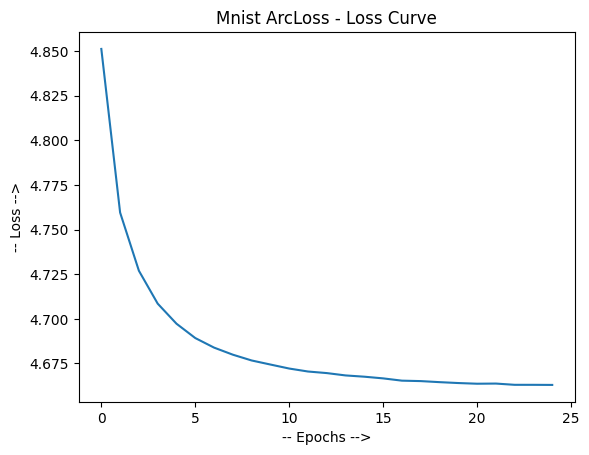

In [11]:
plt.plot(loss_history)
plt.title("Mnist ArcLoss - Loss Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Loss -->")
plt.savefig("arcloss_mnist_loss.png")
plt.show()

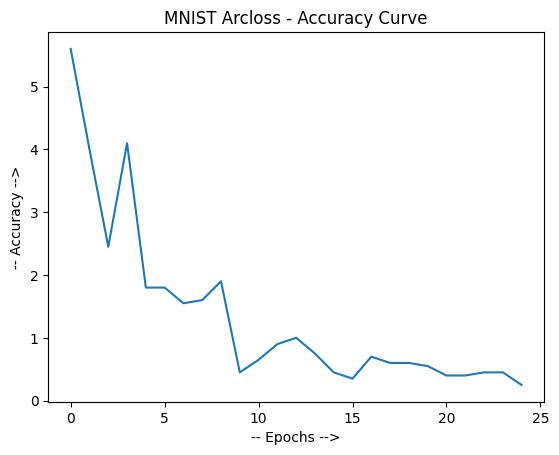

In [12]:
plt.plot(acc_history)
plt.title("MNIST Arcloss - Accuracy Curve")
plt.xlabel("-- Epochs -->")
plt.ylabel("-- Accuracy -->")
plt.savefig("arcloss_mnist_accuracy.png")
plt.show()

In [13]:
# Model accuracy testing
model.eval()
correct = 0
total = 0
optimizer.zero_grad()
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the MNIST test set: {(100 * correct / total):.2f}%")

Testing: 100%|██████████| 16/16 [00:00<00:00, 47.82it/s]

Accuracy on the MNIST test set: 0.25%


In [14]:
# Test the Model

all_labels = []
all_predicted = []

with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        labels = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        
        for lbl in labels.tolist():
            all_labels.append(lbl)

        for pred in predicted.tolist():
            all_predicted.append(pred)

accuracy = metrics.accuracy_score(all_labels, all_predicted)
precision = metrics.precision_score(all_labels, all_predicted, average="weighted")
print("Accuracy:", accuracy)
print("Precision:", precision)

100%|██████████| 16/16 [00:00<00:00, 44.08it/s]

Accuracy: 0.0025
Precision: 0.002062984322996954



c:\Users\91997\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


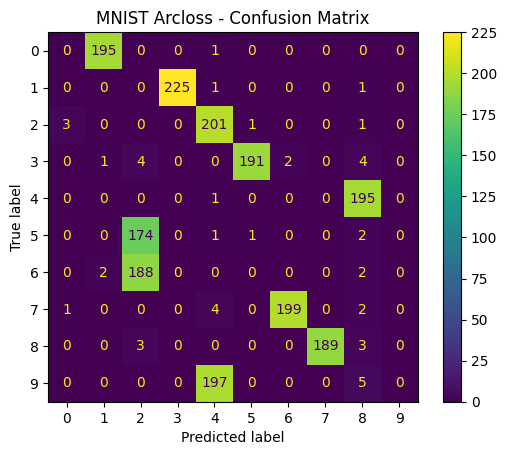

In [15]:
confusion_matrix = metrics.confusion_matrix(all_labels, all_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title("MNIST Arcloss - Confusion Matrix")
plt.savefig("arcloss_mnist_cm.png")
plt.show()